In [65]:
import numpy as np
import pandas as pd
import pandapower as pp
import pandapower.plotting as ppp
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
import pandapower.networks as pn
import os
from pandapower.control import ConstControl
from pandapower.timeseries import OutputWriter
from pandapower.timeseries import DFData
from pandapower.timeseries.run_time_series import run_timeseries
#import itertools 
#import sympy as sym

## Power Generation and Demand Data

### PV Power Generation Trend

Based on EMA's Solar Generation Profile <br>
https://www.ema.gov.sg/consumer-information/solar/solar-generation-profile

In [66]:
time_SGP = (pd.read_csv("20241201-IGS-Generation-Profile.xlsx.coredownload.csv").iloc[:,0]-1)*0.5
SGP_pwr = (pd.read_csv("20241201-IGS-Generation-Profile.xlsx.coredownload.csv").iloc[:,1])*2

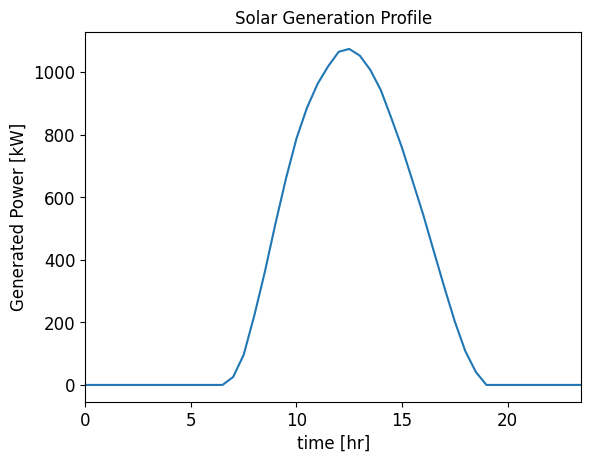

In [67]:
plt.figure()
plt.rc('font', size =12)
plt.rcParams['axes.titlesize'] =12
plt.title('Solar Generation Profile',fontsize=12)
plt.plot(time_SGP,SGP_pwr)
plt.xlim(time_SGP.iloc[0],time_SGP.iloc[-1])
plt.ylabel('Generated Power [kW]')
plt.xlabel('time [hr]')
plt.show()

In [68]:
cumtrapz(SGP_pwr, time_SGP, initial = 0)[-1] #kWh

7291.060000000001

### Residential Power Demand Trend

Singapore Half-Hourly System Demand Data, as of 17 Feb 2025 <br>
https://www.ema.gov.sg/resources/statistics/half-hourly-system-demand-data

In [5]:
time_csv = pd.read_csv("20250217.csv")[0:48].iloc[:,0]
demand = pd.read_csv("20250217.csv")[0:48].iloc[:,1:]
#time = list(map(lambda x: x * 0.5, list(range(1,len(time_csv)+1))))
time = np.array(list(range(0,len(time_csv))))*0.5
demand.head()

,Mon,Tue,Wed,Thu,Fri,Sat,Sun
0,6241.0,6262.0,6236.0,6283.0,6232.0,6065.0,6262.0
1,6116.0,6143.0,6104.0,6147.0,6081.0,5930.0,6130.0
2,6011.0,6024.0,6005.0,6052.0,5942.0,5816.0,6035.0
3,5947.0,5952.0,5939.0,5979.0,5865.0,5724.0,5947.0
4,5879.0,5927.0,5880.0,5915.0,5803.0,5657.0,5883.0


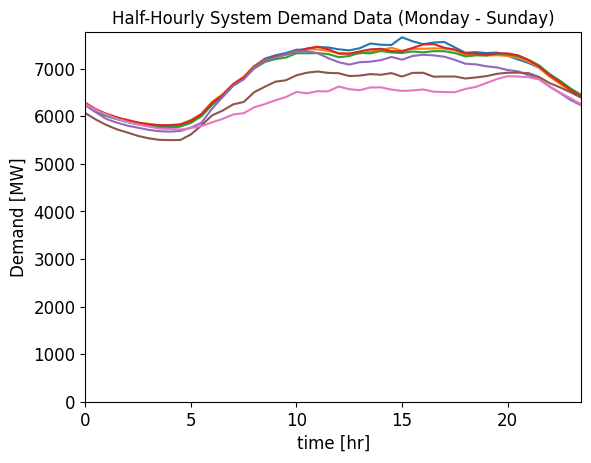

In [6]:
plt.figure()
plt.rc('font', size =12)
plt.rcParams['axes.titlesize'] =12
plt.title('Half-Hourly System Demand Data (Monday - Sunday)',fontsize=12)
plt.plot(time,demand)
plt.xlim(time[0],time[-1])
plt.ylim(0,)
plt.ylabel('Demand [MW]')
plt.xlabel('time [hr]')
plt.show()

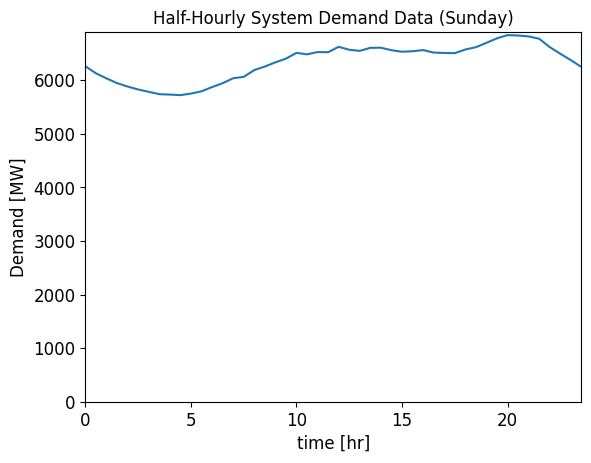

In [7]:
plt.figure()
plt.rc('font', size =12)
plt.rcParams['axes.titlesize'] =12
plt.title('Half-Hourly System Demand Data (Sunday)',fontsize=12)
plt.plot(time,demand.iloc[:,6])
plt.xlim(time[0],time[-1])
plt.ylim(0,)
plt.ylabel('Demand [MW]')
plt.xlabel('time [hr]')
plt.show()

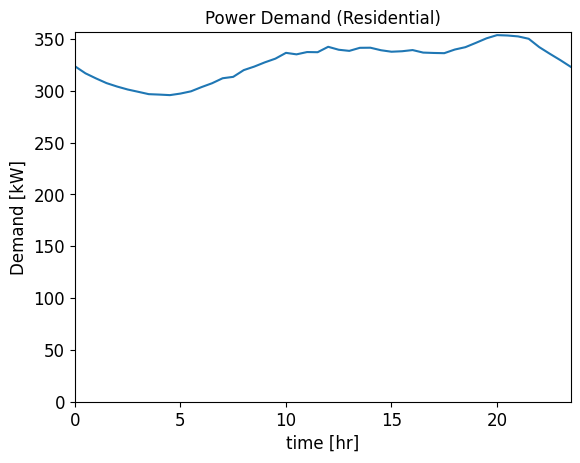

In [8]:
energy_sys_demand = cumtrapz(demand.iloc[:,6], time, initial = 0)*1000 #MWh to kWh
scale_factor = energy_sys_demand[-1]/7700
power_demand_resd = demand.iloc[:,6]*1000/scale_factor #kW
plt.figure()
plt.rc('font', size =12)
plt.rcParams['axes.titlesize'] =12
plt.title('Power Demand (Residential)',fontsize=12)
plt.plot(time,power_demand_resd)
plt.xlim(time[0],time[-1])
plt.ylim(0,)
plt.ylabel('Demand [kW]')
plt.xlabel('time [hr]')
plt.show()

In [9]:
cumtrapz(power_demand_resd, time, initial = 0)[-1] #kWh

7700.000000000004

### Non-residential Power Demand Trend
Based on the commercial load in https://www.researchgate.net/figure/Demand-curve-for-the-residential-industrial-and-commercial-loads_fig3_3266841

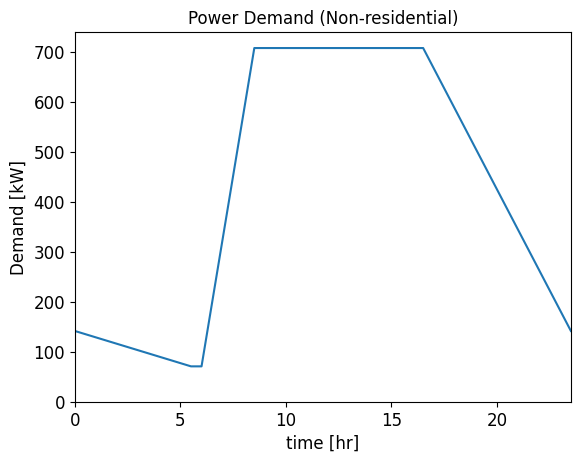

In [10]:
power_demand_non_resd = np.concatenate((np.linspace(0.2, 0.1, 12),np.linspace(0.1, 1, 6),np.linspace(1, 1, 15),np.linspace(1, 0.2, 15)))
scale_factor = cumtrapz(power_demand_non_resd, time, initial = 0)[-1]/10215
power_demand_non_resd = power_demand_non_resd/scale_factor
plt.figure()
plt.rc('font', size =12)
plt.rcParams['axes.titlesize'] =12
plt.title('Power Demand (Non-residential)',fontsize=12)
plt.plot(time,power_demand_non_resd)
plt.xlim(time[0],time[-1])
plt.ylim(0,)
plt.ylabel('Demand [kW]')
plt.xlabel('time [hr]')
plt.show()

In [11]:
cumtrapz(power_demand_non_resd, time, initial = 0)[-1] #kWh

10215.0

## Creating Microgrid

In [12]:
net = pn.create_cigre_network_mv(with_der="all")
net

This pandapower network includes the following parameter tables:
   - bus (15 elements)
   - load (18 elements)
   - sgen (13 elements)
   - storage (2 elements)
   - switch (8 elements)
   - ext_grid (1 element)
   - line (15 elements)
   - trafo (2 elements)
   - bus_geodata (15 elements)

In [13]:
pp.drop_elements_simple(net,element='sgen',idx=8) #dropping wind turbine
pp.drop_elements_simple(net,element='sgen',idx=9) #dropping Residential fuel cell 1
pp.drop_elements_simple(net,element='sgen',idx=12) #dropping Residential fuel cell 2
pp.drop_elements_simple(net,element='sgen',idx=10) #dropping CHP diesel
pp.drop_elements_simple(net,element='sgen',idx=11) #dropping Fuel cell
net.sgen

,name,bus,p_mw,q_mvar,sn_mva,scaling,in_service,type,current_source
0,PV 3,3,0.02,0.0,0.02,1.0,True,PV,True
1,PV 4,4,0.02,0.0,0.02,1.0,True,PV,True
2,PV 5,5,0.03,0.0,0.03,1.0,True,PV,True
3,PV 6,6,0.03,0.0,0.03,1.0,True,PV,True
4,PV 8,8,0.03,0.0,0.03,1.0,True,PV,True
5,PV 9,9,0.03,0.0,0.03,1.0,True,PV,True
6,PV 10,10,0.04,0.0,0.04,1.0,True,PV,True
7,PV 11,11,0.01,0.0,0.01,1.0,True,PV,True


In [14]:
net.storage.iloc[0,2]=1
net.storage.iloc[0,4]=1
net.storage.iloc[0,5]=0.3
net.storage.iloc[0,7]=0.5
net.storage.iloc[0,-2]=-1
net.storage.iloc[0,-1]=1
net.storage.iloc[1,2]=1
net.storage.iloc[1,4]=1
net.storage.iloc[1,5]=0.3
net.storage.iloc[1,7]=0.5
net.storage.iloc[1,-2]=-1
net.storage.iloc[1,-1]=1
net.storage

,name,bus,p_mw,q_mvar,sn_mva,soc_percent,min_e_mwh,max_e_mwh,scaling,in_service,type,min_p_mw,max_p_mw
0,Battery 1,5,1.0,0.0,1.0,0.3,0.0,0.5,1.0,True,Battery,-1.0,1.0
1,Battery 2,10,1.0,0.0,1.0,0.3,0.0,0.5,1.0,True,Battery,-1.0,1.0


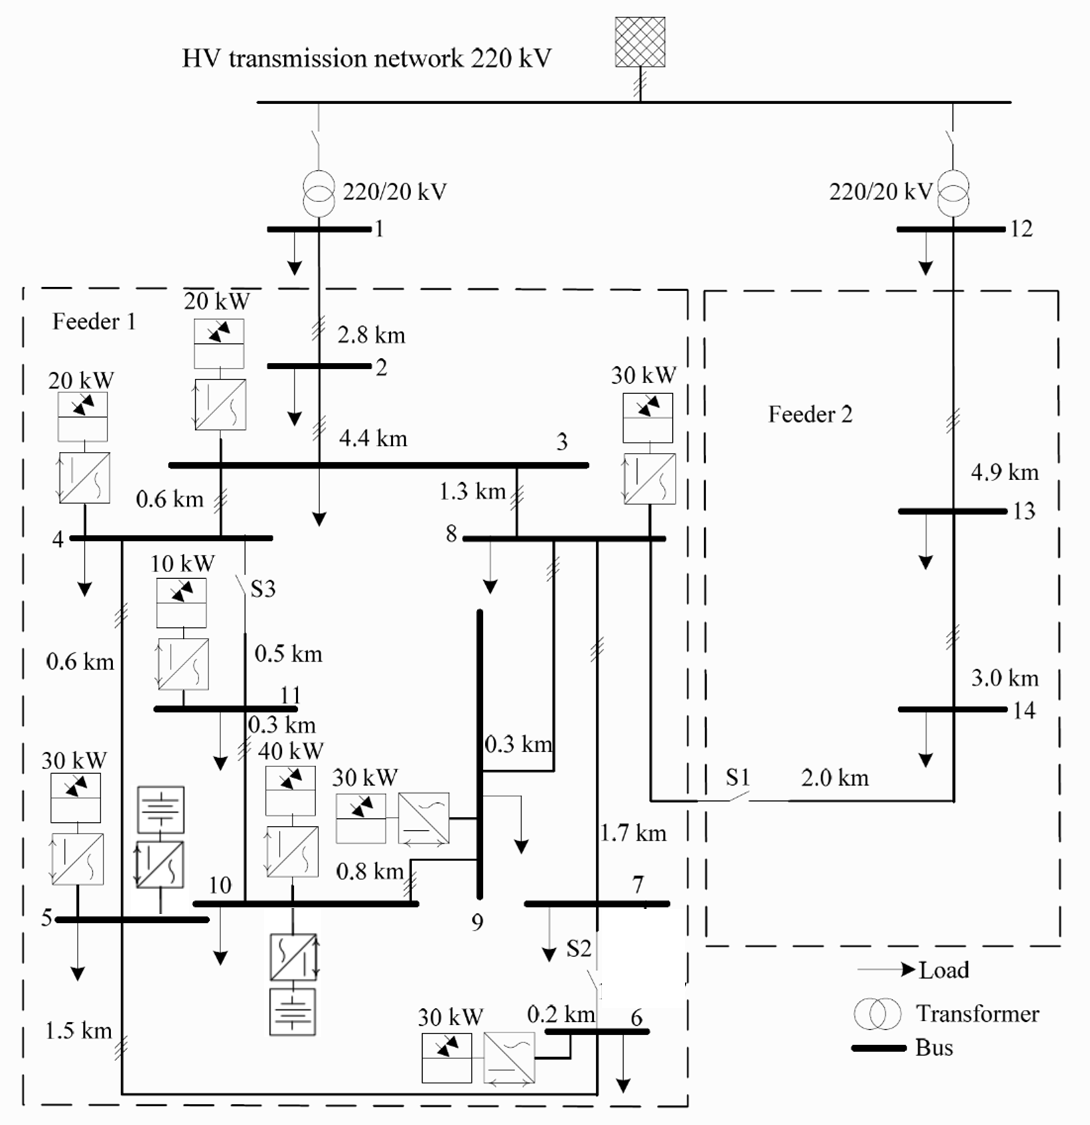

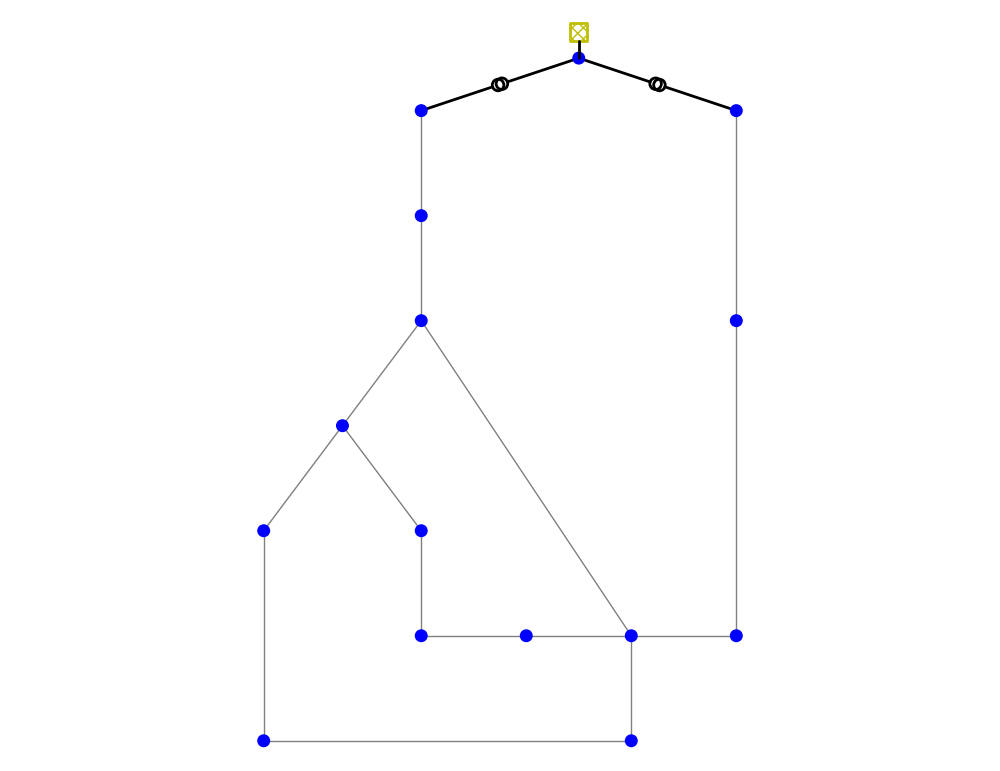

<AxesSubplot:>

In [15]:
ppp.simple_plot(net)

## Scaling data to fit into microgrid

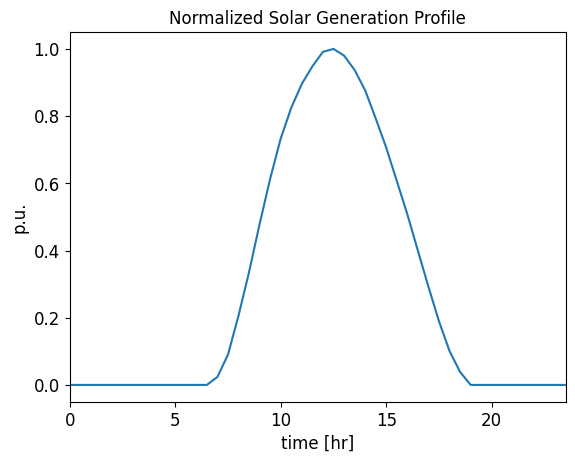

In [16]:
PV_PU=SGP_pwr/max(SGP_pwr)
plt.figure()
plt.rc('font', size =12)
plt.rcParams['axes.titlesize'] =12
plt.title('Normalized Solar Generation Profile',fontsize=12)
plt.plot(time_SGP,PV_PU)
plt.xlim(time_SGP.iloc[0],time_SGP.iloc[-1])
plt.ylabel('p.u.')
plt.xlabel('time [hr]')
plt.show()

In [17]:
print(SGP_pwr[25]) #value of max power generated
print(max(SGP_pwr)==SGP_pwr[25]) #max power gnerated is at 25th index
print((power_demand_resd+power_demand_non_resd)[25]) #power demand at 25th index
diff = SGP_pwr[25]-(power_demand_resd+power_demand_non_resd)[25] #maximum difference is 210*0.3 = 63kW (based on PV connected to grid 
#in above network diagram), else the load will be supplying power
print(diff) #excess power generated at 25th index < 63kW

1074.624
True
1046.5732695838724
28.050730416127635


In [18]:
print(net.load.iloc[:,2]*1000) #kw

0     14994.00
1       276.45
2       431.65
3       727.50
4       548.05
5       586.85
6       475.30
7       329.80
8     14994.00
9       208.55
10     4845.00
11      225.25
12       76.50
13      573.75
14       68.00
15     5016.00
16       34.00
17      331.50
Name: p_mw, dtype: float64


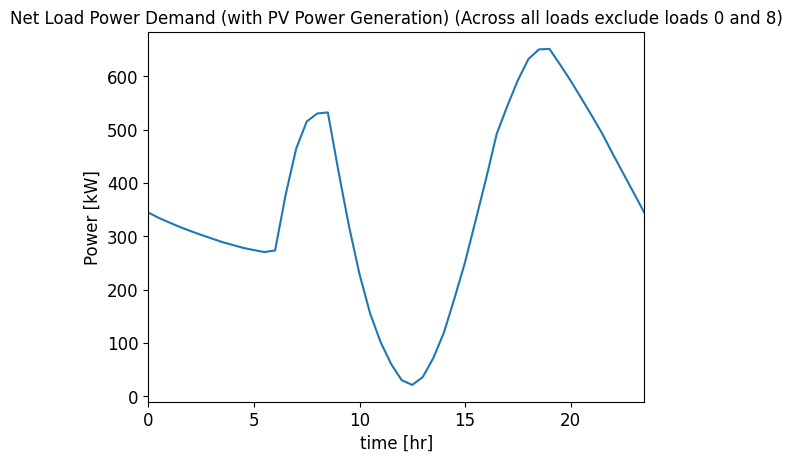

In [19]:
#print((power_demand_resd+power_demand_non_resd-PV_PU*(max(SGP_pwr)-210.737)))
net_load_demand_PV = power_demand_resd*5/7+power_demand_non_resd*0.8-PV_PU*(max(SGP_pwr)-210*0.3)*7/9 #Load power demand does not reach zero
plt.figure()
plt.rc('font', size =12)
plt.rcParams['axes.titlesize'] =12
plt.title('Net Load Power Demand (with PV Power Generation) (Across all loads exclude loads 0 and 8)',fontsize=12)
plt.plot(time,net_load_demand_PV)
plt.xlim(time[0],time[-1])
plt.ylabel('Power [kW]')
plt.xlabel('time [hr]')
plt.show()
#min(net_load_demand_PV) #Load power demand does not reach zero

In [20]:
print(net.load.iloc[:,2]*1000) #kw
total = 0
for i in range(len(net.load.iloc[:,2])):
    if ((i!=0)&(i!=8)):
        #print(i)
        total = total+net.load.iloc[i,2]*1000
print( "In CIGRE network, max possible active power demand by all load (exlude 0 and 8) = " + str(total) + ' kW')
print( "In UTown MG, max active power demand by 5/7 of resd load and 0.8 of non-resd load (with 7/9 PV power generation) = " + str(max(net_load_demand_PV)) + ' kW')
power_scale_factor = max(net_load_demand_PV)/total
power_scale_factor

0     14994.00
1       276.45
2       431.65
3       727.50
4       548.05
5       586.85
6       475.30
7       329.80
8     14994.00
9       208.55
10     4845.00
11      225.25
12       76.50
13      573.75
14       68.00
15     5016.00
16       34.00
17      331.50
Name: p_mw, dtype: float64
In CIGRE network, max possible active power demand by all load (exlude 0 and 8) = 14754.150000000001 kW
In UTown MG, max active power demand by 5/7 of resd load and 0.8 of non-resd load (with 7/9 PV power generation) = 651.3272639457285 kW


0.04414536004756143

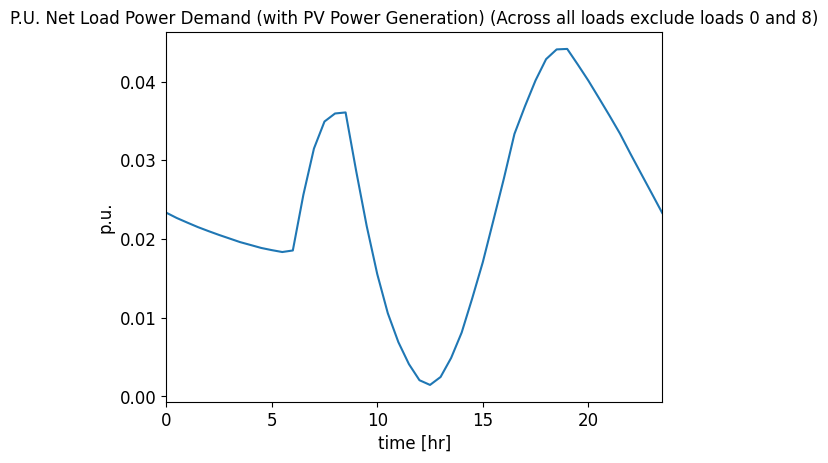

In [21]:
load_PU=(net_load_demand_PV/max(net_load_demand_PV)*power_scale_factor).to_numpy()
plt.figure()
plt.rc('font', size =12)
plt.rcParams['axes.titlesize'] =12
plt.title('P.U. Net Load Power Demand (with PV Power Generation) (Across all loads exclude loads 0 and 8)',fontsize=12)
plt.plot(time,load_PU)
plt.xlim(time[0],time[-1])
plt.ylabel('p.u.')
plt.xlabel('time [hr]')
plt.show()

In [22]:
load0_max =net.load.iloc[0,2]*1000
load8_max =net.load.iloc[8,2]*1000
print(load0_max) #kW
print(load8_max) #kW

14994.0
14994.0


In [23]:
load_0 = power_demand_resd*2/7-PV_PU*(max(SGP_pwr)-210)/9
print(str(max(load_0)))
PU_load_0 = (load_0/net.load.iloc[0,2]/1000).to_numpy()
print(max(PU_load_0))
load_8 = power_demand_non_resd*0.2-PV_PU*(max(SGP_pwr)-210)/9
print(str(max(load_8)))
PU_load_8 = (load_8/net.load.iloc[8,2]/1000).to_numpy()
print(max(PU_load_8))

101.07608099057863
0.006741101840107951
109.11208765062462
0.00727704999670699


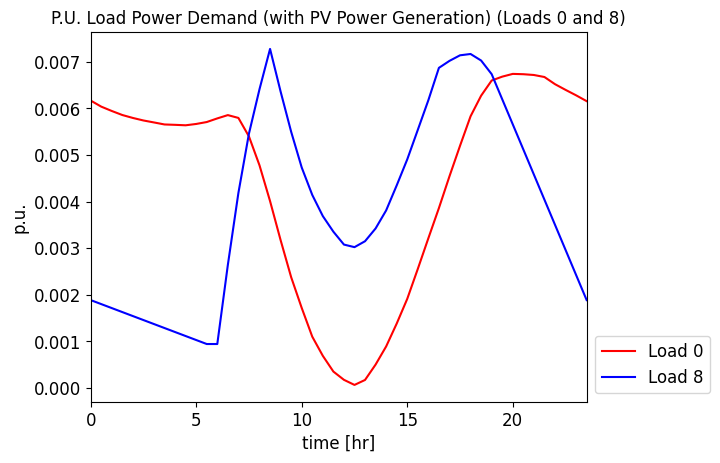

In [24]:
plt.figure()
plt.rc('font', size =12)
plt.rcParams['axes.titlesize'] =12
plt.title('P.U. Load Power Demand (with PV Power Generation) (Loads 0 and 8)',fontsize=12)
plt.plot(time,PU_load_0,'red', label = "Load 0")
plt.plot(time,PU_load_8,'blue', label = "Load 8")
plt.legend(loc="lower left", bbox_to_anchor = (1.0,0.0))
plt.xlim(time[0],time[-1])
plt.ylabel('p.u.')
plt.xlabel('time [hr]')
plt.show()

## Control Setup - Pandapower Timeseries Simulation (CIGRE Network - UTown Microgrid) 

In [25]:
num_intervals = len(power_demand_non_resd)
time_steps = np.arange(num_intervals)
start_time = pd.to_datetime("2025-04-23 00:00:00")
index_time = start_time + pd.to_timedelta(time_steps * 0.5, unit='h')  #half-hourly
df_load_profile = pd.DataFrame(load_PU, index=index_time,columns=['load'])
ds = DFData(df_load_profile)
df_load_profile_0 = pd.DataFrame(PU_load_0, index=index_time,columns=['load'])
ds_0 = DFData(df_load_profile_0)
df_load_profile_8 = pd.DataFrame(PU_load_8, index=index_time,columns=['load'])
ds_8 = DFData(df_load_profile_8)
for i in net.load.index:
    if (i==0):
        ConstControl(net,element = 'load',variable='p_mw',element_index=i,data_source=ds_0, profile_name='load') 
    elif (i==8):
        ConstControl(net,element = 'load',variable='p_mw',element_index=i,data_source=ds_8, profile_name='load')
    else:
        ConstControl(net,element = 'load',variable='p_mw',element_index=i,data_source=ds, profile_name='load')
PV_PU = PV_PU.to_numpy()
df_load_profile = pd.DataFrame(PV_PU*0.3, index=index_time,columns=['sgen'])
ds = DFData(df_load_profile)
for i in net.sgen.index:
    ConstControl(net,element = 'sgen',variable='p_mw',element_index=i,data_source=ds, profile_name='sgen')
time_steps_for_run = df_load_profile.index

In [26]:
ow = OutputWriter(net, time_steps, output_path='UTownMGControl', output_file_type=".xlsx", log_variables=list())
# these variables are saved to the harddisk after / during the time series loop
ow.log_variable('res_load', 'p_mw')
ow.log_variable('res_bus', 'vm_pu')
ow.log_variable('res_line', 'loading_percent')

In [27]:
run_timeseries(net,time_steps_for_run)  

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:05<00:00,  8.22it/s]


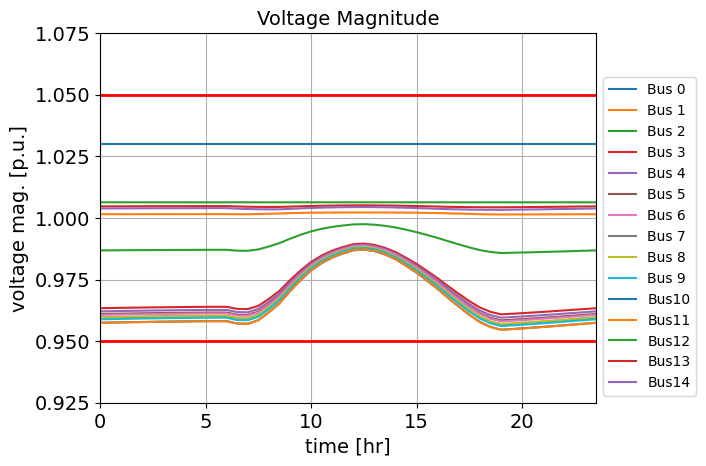

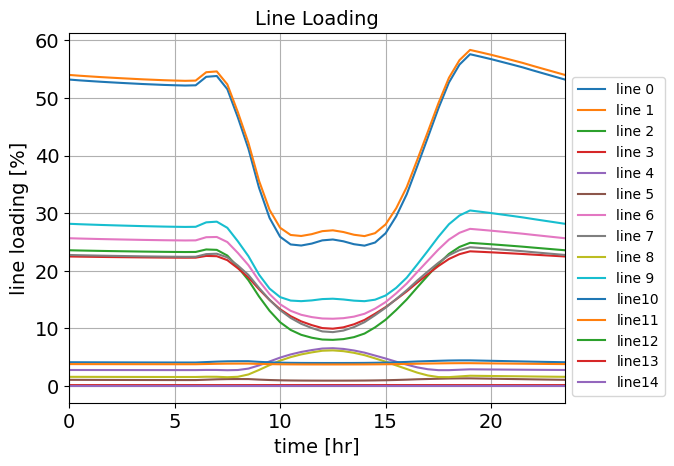

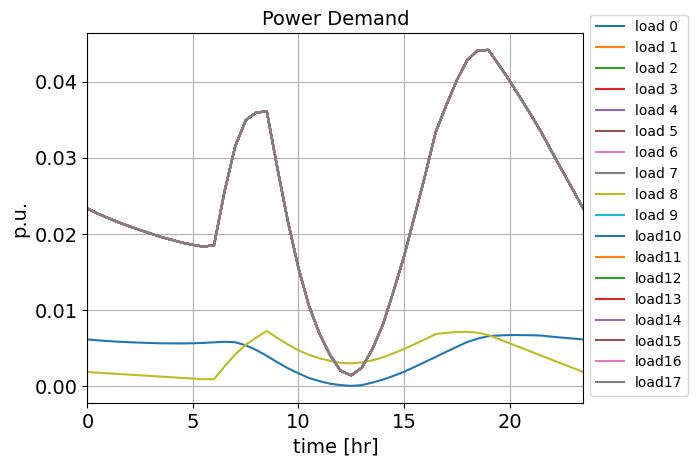

In [28]:
vm_pu = pd.read_excel("UTownMGControl/res_bus/vm_pu.xlsx", index_col=0)
plt.figure()
plt.rc('font', size =14)
x,Y = np.shape(vm_pu)
for i in range(Y):
    plt.plot(time,vm_pu[i], label = "Bus{0:2d}".format(vm_pu.columns.values[i]))
plt.xlabel("time [hr]")
plt.ylabel("voltage mag. [p.u.]")
plt.title("Voltage Magnitude", fontsize = 14)
plt.xlim(time[0],time[-1])
plt.axhline(0.95,c='red',lw=2)
plt.axhline(1.05,c='red',lw=2)
plt.yticks(np.linspace(0.925,1.075, 7))
plt.legend(loc = "lower left",bbox_to_anchor = (1,0), fontsize =10)
plt.grid()
plt.show()


line_loading = pd.read_excel("UTownMGControl/res_line/loading_percent.xlsx", index_col=0)
plt.figure()
x,Y = np.shape(line_loading)
for i in range(Y):
    plt.plot(time,line_loading[i], label = "line{0:2d}".format(line_loading.columns.values[i]))
plt.xlim(time[0],time[-1])
plt.legend(loc = "lower left",bbox_to_anchor = (1,0), fontsize =10)
plt.xlabel("time [hr]")
plt.ylabel("line loading [%]")
plt.title("Line Loading", fontsize =14)
plt.grid()
plt.show()


load = pd.read_excel("UTownMGControl/res_load/p_mw.xlsx", index_col=0)
plt.figure()
x,Y = np.shape(load)
for i in range(Y):
    plt.plot(time,load[i], label = "load{0:2d}".format(load.columns.values[i]))
plt.xlim(time[0],time[-1])
plt.xlabel("time [hr]")
plt.ylabel("p.u.")
plt.title("Power Demand", fontsize =14)
plt.legend(loc = "lower left",bbox_to_anchor = (1,0), fontsize =10)
plt.grid()
plt.show()

## Scenario Simulation- Pandapower Timeseries Simulation (CIGRE Network - UTown Microgrid)

## With EV Charging

### Assume 4 L2 Charger & 4 DC Fast Chargers Per Carpark 
#### One carpark at load 0 (Residential Load) and another carpark at load 8 (Non-Residential Load)
#### Based on data from MyTransport app
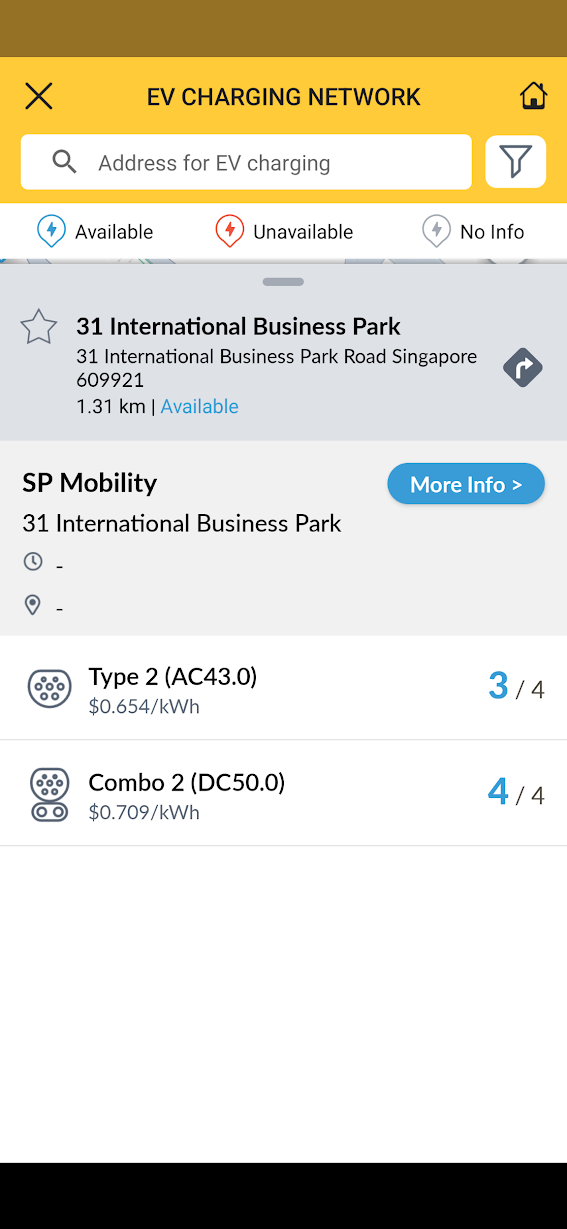

Taking into account power loss of 4% from grid to DC Fast charger<BR>
Taking into account power loss of 10.6% from grid to L2 charger

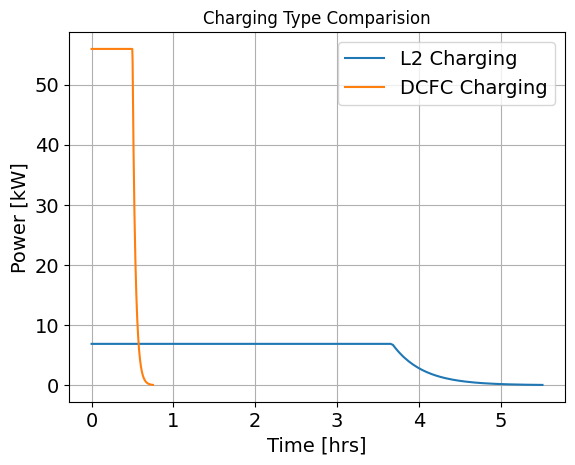

In [29]:
L2 = pd.read_csv("L2_charge.csv")*100/96 #5.51 hours #0.02770403hr time interval
DCFC = pd.read_csv("DC_fast_charge.csv")*100/89.4 #0.75 hours #0.0037524hr time interval
L2_time = (np.linspace(0, 5.51, len(L2)))
DCFC_time = (np.linspace(0, 0.75, len(DCFC)))

plt.figure()
plt.plot(L2_time, L2, label='L2 Charging')
plt.plot(DCFC_time, DCFC, label='DCFC Charging')
plt.xlabel('Time [hrs]')  # Label the x-axis
plt.ylabel('Power [kW]')  # Label the y-axis
plt.title('Charging Type Comparision')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
DCFC_load=np.array([55.928412,55.928412*0.97])
time_DCFC=np.array([0,0.5])
#cumtrapz(DCFC_load,time_DCFC,initial=0)[-1]
L2_load=np.array([6.875,6.875,6.875,6.875,6.875,6.875,6.875,6.875,float(L2.iloc[145]),float(L2.iloc[163]),float(L2.iloc[181]),0])
time_L2=np.linspace(0,6,12)
#cumtrapz(L2_load,time_L2,initial=0)[-1]

## Scenario 1 - Expected Amount of EV Charging Activity

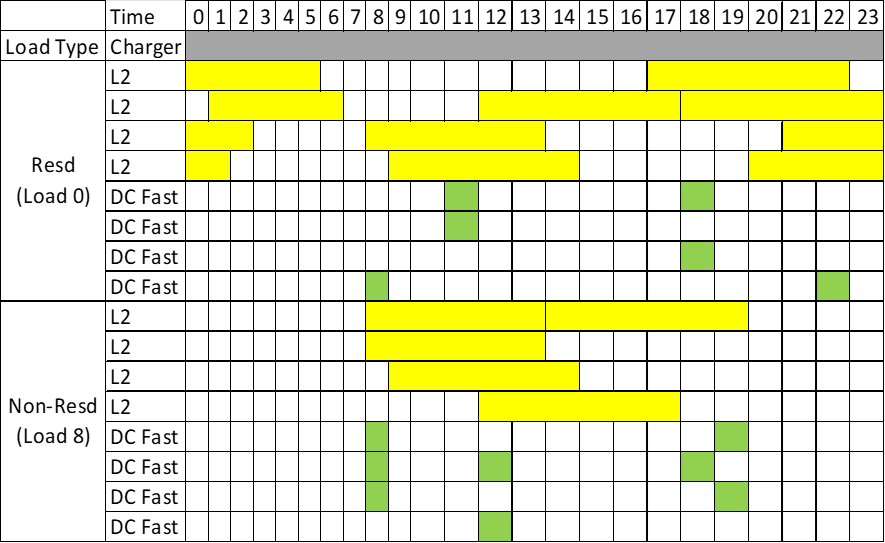

#### Grid Setup

In [31]:
net = pn.create_cigre_network_mv(with_der="all")
pp.drop_elements_simple(net,element='sgen',idx=8) #dropping wind turbine
pp.drop_elements_simple(net,element='sgen',idx=9) #dropping Residential fuel cell 1
pp.drop_elements_simple(net,element='sgen',idx=12) #dropping Residential fuel cell 2
pp.drop_elements_simple(net,element='sgen',idx=10) #dropping CHP diesel
pp.drop_elements_simple(net,element='sgen',idx=11) #dropping Fuel cell
net.storage.iloc[0,2]=1
net.storage.iloc[0,4]=1
net.storage.iloc[0,5]=0.3
net.storage.iloc[0,7]=0.5
net.storage.iloc[0,-2]=-1
net.storage.iloc[0,-1]=1
net.storage.iloc[1,2]=1
net.storage.iloc[1,4]=1
net.storage.iloc[1,5]=0.3
net.storage.iloc[1,7]=0.5
net.storage.iloc[1,-2]=-1
net.storage.iloc[1,-1]=1

#### Residential (Load 0)

In [32]:
load_0 = power_demand_resd*2/7-PV_PU*(max(SGP_pwr)-210)/9
load_0_scen1 = np.zeros(48)
load_0_scen1[16:18]=DCFC_load
load_0_scen1[22:24]=DCFC_load*2
load_0_scen1[36:38]=DCFC_load*2
load_0_scen1[44:46]=DCFC_load
load_0_scen1[0:12]=load_0_scen1[0:12]+L2_load
load_0_scen1[2:14]=load_0_scen1[2:14]+L2_load
load_0_scen1[16:28]=load_0_scen1[16:28]+L2_load
load_0_scen1[18:30]=load_0_scen1[18:30]+L2_load
load_0_scen1[24:36]=load_0_scen1[24:36]+L2_load
load_0_scen1[34:46]=load_0_scen1[34:46]+L2_load
load_0_scen1[36:48]=load_0_scen1[36:48]+L2_load

load_0_scen1[40:48]=load_0_scen1[40:48]+L2_load[0:8]
load_0_scen1[0:4]=load_0_scen1[0:4]+L2_load[8:12]
load_0_scen1[42:48]=load_0_scen1[42:48]+L2_load[0:6]
load_0_scen1[0:6]=load_0_scen1[0:6]+L2_load[6:12]

load_0_scen1=load_0.to_numpy()+load_0_scen1

In [33]:
#load0_max
PU_load_0_scen1=(load_0_scen1/load0_max)

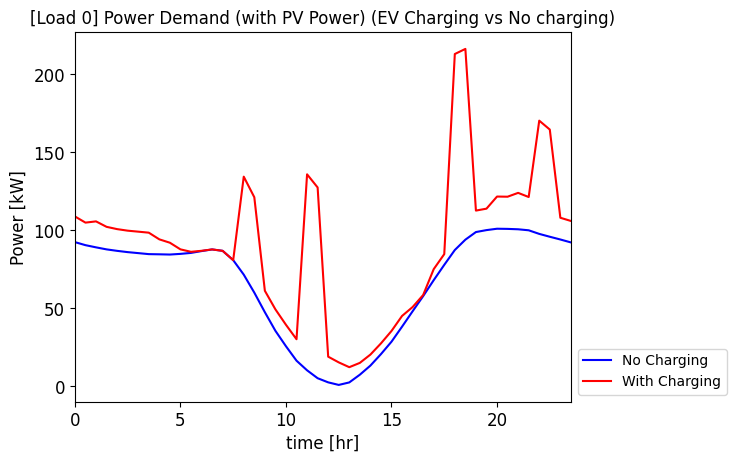

In [34]:
plt.figure()
plt.rc('font', size =12)
plt.rcParams['axes.titlesize'] =12
plt.title('[Load 0] Power Demand (with PV Power) (EV Charging vs No charging)',fontsize=12)
plt.plot(time,load_0,'blue', label = "No Charging")
plt.plot(time,load_0_scen1,'red', label = "With Charging")
plt.xlim(time[0],time[-1])
plt.legend(loc = "lower left",bbox_to_anchor = (1,0), fontsize =10)
plt.ylabel('Power [kW]')
plt.xlabel('time [hr]')
plt.show()

In [35]:
PU_load_0

array([6.16875343e-03, 6.03871902e-03, 5.94513366e-03, 5.85844405e-03,
       5.79539707e-03, 5.74121606e-03, 5.69885637e-03, 5.65551157e-03,
       5.64763070e-03, 5.63777960e-03, 5.66634777e-03, 5.70772235e-03,
       5.78554598e-03, 5.85647383e-03, 5.79593217e-03, 5.39827242e-03,
       4.77821103e-03, 4.01051548e-03, 3.17263174e-03, 2.37746016e-03,
       1.71753491e-03, 1.10069001e-03, 6.89345748e-04, 3.51645431e-04,
       1.74492702e-04, 6.49819488e-05, 1.71553083e-04, 5.01586568e-04,
       8.90865039e-04, 1.38126349e-03, 1.91251091e-03, 2.55490254e-03,
       3.21286707e-03, 3.86095530e-03, 4.54291493e-03, 5.19739853e-03,
       5.83151589e-03, 6.27323489e-03, 6.59924612e-03, 6.68199529e-03,
       6.74110184e-03, 6.73420608e-03, 6.71745922e-03, 6.67411442e-03,
       6.52043739e-03, 6.39828386e-03, 6.28105587e-03, 6.15594701e-03])

#### Non-Residential (Load 8)

In [36]:
load_8 = power_demand_non_resd*0.2-PV_PU*(max(SGP_pwr)-210)/9
load_8_scen1 = np.zeros(48)
load_8_scen1[16:18]=DCFC_load*3
load_8_scen1[24:26]=DCFC_load*2
load_8_scen1[36:38]=DCFC_load
load_8_scen1[38:40]=load_8_scen1[38:40]+DCFC_load*2
load_8_scen1[16:28]=load_8_scen1[16:28]+L2_load*2
load_8_scen1[18:30]=load_8_scen1[18:30]+L2_load
load_8_scen1[24:36]=load_8_scen1[24:36]+L2_load
load_8_scen1[28:40]=load_8_scen1[28:40]+L2_load
load_8_scen1=load_8+load_8_scen1

In [37]:
#load8_max
PU_load_8_scen1=(load_8_scen1/load8_max)

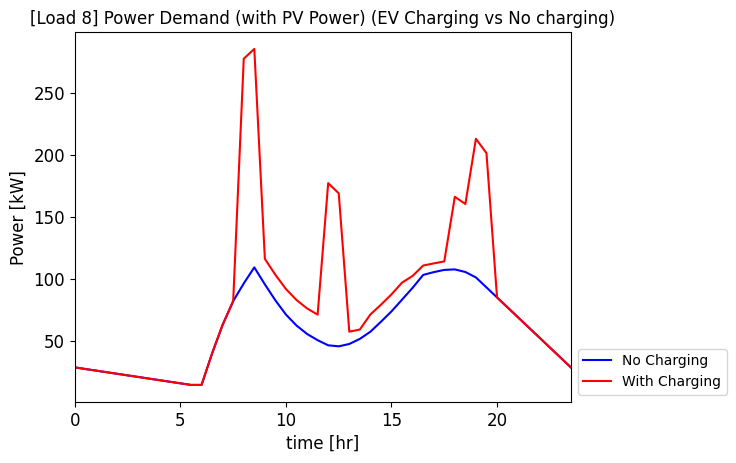

In [38]:
plt.figure()
plt.rc('font', size =12)
plt.rcParams['axes.titlesize'] =12
plt.title('[Load 8] Power Demand (with PV Power) (EV Charging vs No charging)',fontsize=12)
plt.plot(time,load_8,'blue', label = "No Charging")
plt.plot(time,load_8_scen1,'red', label = "With Charging")
plt.xlim(time[0],time[-1])
plt.legend(loc = "lower left",bbox_to_anchor = (1,0), fontsize =10)
plt.ylabel('Power [kW]')
plt.xlabel('time [hr]')
plt.show()

#### Results

In [39]:
num_intervals = len(power_demand_non_resd)
time_steps = np.arange(num_intervals)
start_time = pd.to_datetime("2025-04-23 00:00:00")
index_time = start_time + pd.to_timedelta(time_steps * 0.5, unit='h')  #half-hourly
df_load_profile = pd.DataFrame(load_PU, index=index_time,columns=['load'])
ds = DFData(df_load_profile)
df_load_profile_0 = pd.DataFrame(PU_load_0_scen1, index=index_time,columns=['load'])
ds_0 = DFData(df_load_profile_0)
df_load_profile_8 = pd.DataFrame(PU_load_8_scen1, index=index_time,columns=['load'])
ds_8 = DFData(df_load_profile_8)
for i in net.load.index:
    if (i==0):
        ConstControl(net,element = 'load',variable='p_mw',element_index=i,data_source=ds_0, profile_name='load') 
    elif (i==8):
        ConstControl(net,element = 'load',variable='p_mw',element_index=i,data_source=ds_8, profile_name='load')
    else:
        ConstControl(net,element = 'load',variable='p_mw',element_index=i,data_source=ds, profile_name='load')
df_load_profile = pd.DataFrame(PV_PU*0.3, index=index_time,columns=['sgen'])
ds = DFData(df_load_profile)
for i in net.sgen.index:
    ConstControl(net,element = 'sgen',variable='p_mw',element_index=i,data_source=ds, profile_name='sgen')
time_steps_for_run = df_load_profile.index

In [40]:
ow = OutputWriter(net, time_steps, output_path='UTownMGScen1', output_file_type=".xlsx", log_variables=list())
# these variables are saved to the harddisk after / during the time series loop
ow.log_variable('res_load', 'p_mw')
ow.log_variable('res_bus', 'vm_pu')
ow.log_variable('res_line', 'loading_percent')

In [41]:
run_timeseries(net,time_steps_for_run)  

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 72.01it/s]


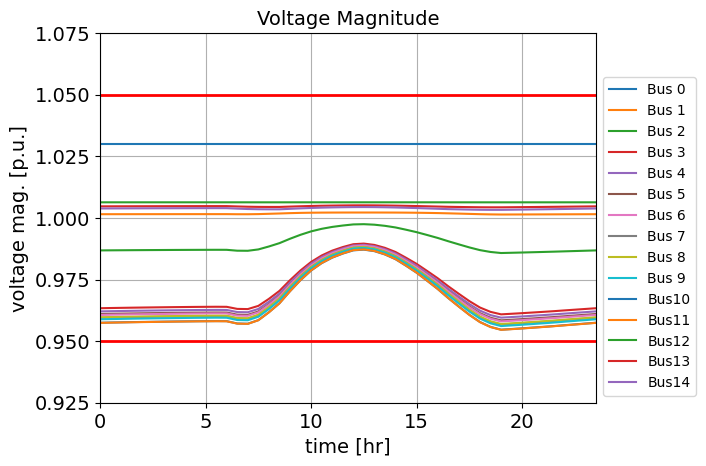

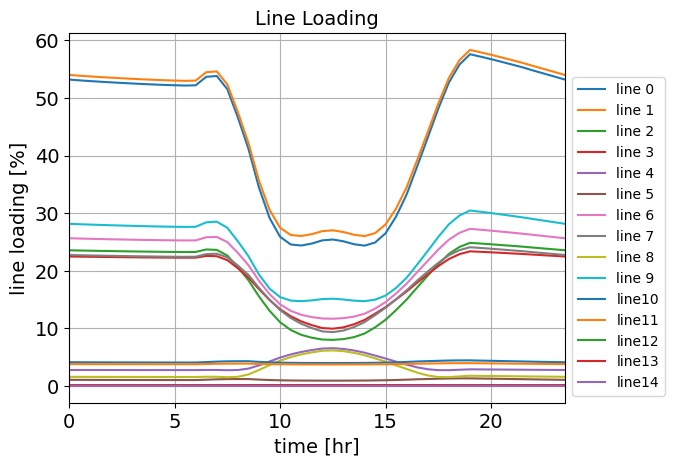

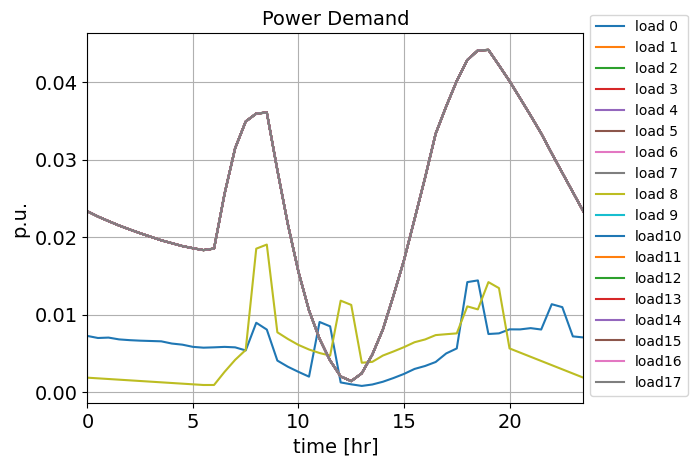

In [42]:
vm_pu = pd.read_excel("UTownMGScen1/res_bus/vm_pu.xlsx", index_col=0)
plt.figure()
plt.rc('font', size =14)
x,Y = np.shape(vm_pu)
for i in range(Y):
    plt.plot(time,vm_pu[i], label = "Bus{0:2d}".format(vm_pu.columns.values[i]))
plt.xlabel("time [hr]")
plt.ylabel("voltage mag. [p.u.]")
plt.title("Voltage Magnitude", fontsize = 14)
plt.xlim(time[0],time[-1])
plt.axhline(0.95,c='red',lw=2)
plt.axhline(1.05,c='red',lw=2)
plt.yticks(np.linspace(0.925,1.075, 7))
plt.legend(loc = "lower left",bbox_to_anchor = (1,0), fontsize =10)
plt.grid()
plt.show()


line_loading = pd.read_excel("UTownMGScen1/res_line/loading_percent.xlsx", index_col=0)
plt.figure()
x,Y = np.shape(line_loading)
for i in range(Y):
    plt.plot(time,line_loading[i], label = "line{0:2d}".format(line_loading.columns.values[i]))
plt.xlim(time[0],time[-1])
plt.legend(loc = "lower left",bbox_to_anchor = (1,0), fontsize =10)
plt.xlabel("time [hr]")
plt.ylabel("line loading [%]")
plt.title("Line Loading", fontsize =14)
plt.grid()
plt.show()


load = pd.read_excel("UTownMGScen1/res_load/p_mw.xlsx", index_col=0)
plt.figure()
x,Y = np.shape(load)
for i in range(Y):
    plt.plot(time,load[i], label = "load{0:2d}".format(load.columns.values[i]))
plt.xlim(time[0],time[-1])
plt.xlabel("time [hr]")
plt.ylabel("p.u.")
plt.title("Power Demand", fontsize =14)
plt.legend(loc = "lower left",bbox_to_anchor = (1,0), fontsize =10)
plt.grid()
plt.show()

## Scenario 2 - Max Amount of EV Charging Activity

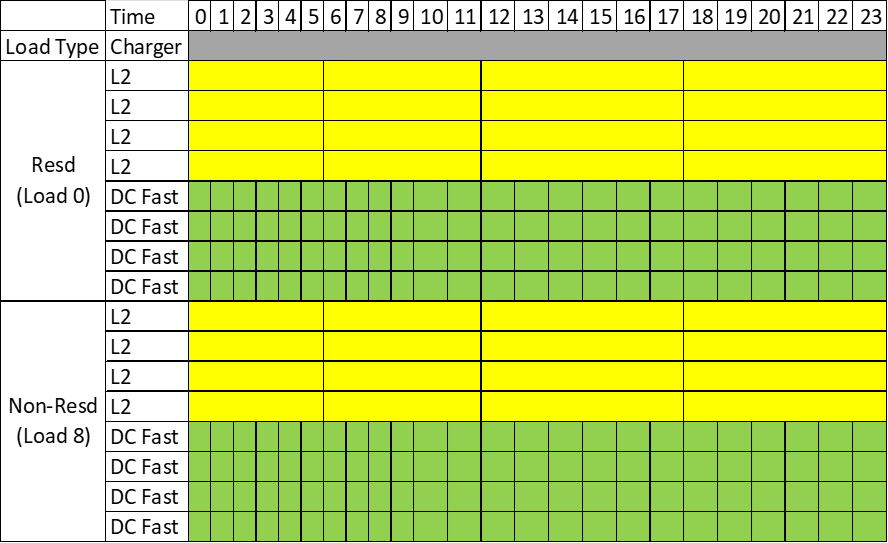

#### Grid Setup

In [43]:
net = pn.create_cigre_network_mv(with_der="all")
pp.drop_elements_simple(net,element='sgen',idx=8) #dropping wind turbine
pp.drop_elements_simple(net,element='sgen',idx=9) #dropping Residential fuel cell 1
pp.drop_elements_simple(net,element='sgen',idx=12) #dropping Residential fuel cell 2
pp.drop_elements_simple(net,element='sgen',idx=10) #dropping CHP diesel
pp.drop_elements_simple(net,element='sgen',idx=11) #dropping Fuel cell
net.storage.iloc[0,2]=1
net.storage.iloc[0,4]=1
net.storage.iloc[0,5]=0.3
net.storage.iloc[0,7]=0.5
net.storage.iloc[0,-2]=-1
net.storage.iloc[0,-1]=1
net.storage.iloc[1,2]=1
net.storage.iloc[1,4]=1
net.storage.iloc[1,5]=0.3
net.storage.iloc[1,7]=0.5
net.storage.iloc[1,-2]=-1
net.storage.iloc[1,-1]=1

#### Residential (Load 0)

In [44]:
load_0 = power_demand_resd*2/7-PV_PU*(max(SGP_pwr)-210)/9
load_0_scen2 = np.concatenate((DCFC_load,DCFC_load,DCFC_load,DCFC_load,DCFC_load,DCFC_load))
load_0_scen2 = L2_load+load_0_scen2
load_0_scen2 = np.concatenate((load_0_scen2,load_0_scen2,load_0_scen2,load_0_scen2))
load_0_scen2=load_0+load_0_scen2*4

In [45]:
#load0_max
PU_load_0_scen2=(load_0_scen2/load0_max)

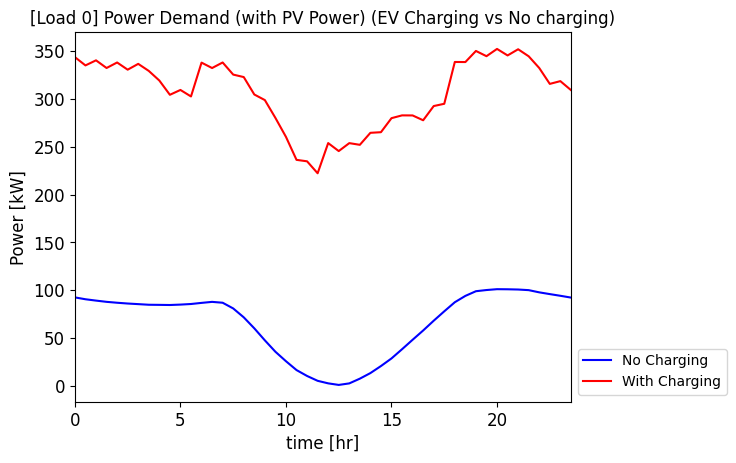

In [46]:
plt.figure()
plt.rc('font', size =12)
plt.rcParams['axes.titlesize'] =12
plt.title('[Load 0] Power Demand (with PV Power) (EV Charging vs No charging)',fontsize=12)
plt.plot(time,load_0,'blue', label = "No Charging")
plt.plot(time,load_0_scen2,'red', label = "With Charging")
plt.xlim(time[0],time[-1])
plt.legend(loc = "lower left",bbox_to_anchor = (1,0), fontsize =10)
plt.ylabel('Power [kW]')
plt.xlabel('time [hr]')
plt.show()

#### Non-Residential (Load 8)

In [47]:
load_8 = power_demand_non_resd*0.2-PV_PU*(max(SGP_pwr)-210)/9
load_8_scen2 = np.concatenate((DCFC_load,DCFC_load,DCFC_load,DCFC_load,DCFC_load,DCFC_load))
load_8_scen2 = L2_load+load_8_scen2
load_8_scen2 = np.concatenate((load_8_scen2,load_8_scen2,load_8_scen2,load_8_scen2))
load_8_scen2=load_8+load_8_scen2*4

In [48]:
#load8_max
PU_load_8_scen2=(load_8_scen2/load8_max)

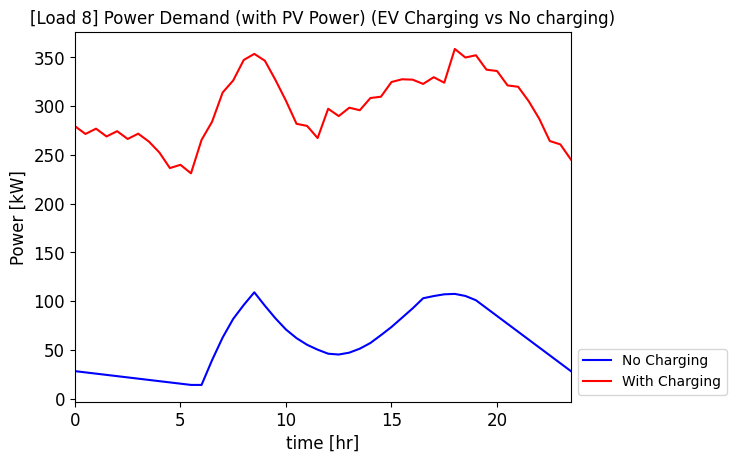

In [49]:
plt.figure()
plt.rc('font', size =12)
plt.rcParams['axes.titlesize'] =12
plt.title('[Load 8] Power Demand (with PV Power) (EV Charging vs No charging)',fontsize=12)
plt.plot(time,load_8,'blue', label = "No Charging")
plt.plot(time,load_8_scen2,'red', label = "With Charging")
plt.xlim(time[0],time[-1])
plt.legend(loc = "lower left",bbox_to_anchor = (1,0), fontsize =10)
plt.ylabel('Power [kW]')
plt.xlabel('time [hr]')
plt.show()

#### Results

In [50]:
num_intervals = len(power_demand_non_resd)
time_steps = np.arange(num_intervals)
start_time = pd.to_datetime("2025-04-23 00:00:00")
index_time = start_time + pd.to_timedelta(time_steps * 0.5, unit='h')  #half-hourly
df_load_profile = pd.DataFrame(load_PU, index=index_time,columns=['load'])
ds = DFData(df_load_profile)
df_load_profile_0 = pd.DataFrame(PU_load_0_scen2.to_numpy(), index=index_time,columns=['load'])
ds_0 = DFData(df_load_profile_0)
df_load_profile_8 = pd.DataFrame(PU_load_8_scen2, index=index_time,columns=['load'])
ds_8 = DFData(df_load_profile_8)
for i in net.load.index:
    if (i==0):
        ConstControl(net,element = 'load',variable='p_mw',element_index=i,data_source=ds_0, profile_name='load') 
    elif (i==8):
        ConstControl(net,element = 'load',variable='p_mw',element_index=i,data_source=ds_8, profile_name='load')
    else:
        ConstControl(net,element = 'load',variable='p_mw',element_index=i,data_source=ds, profile_name='load')
df_load_profile = pd.DataFrame(PV_PU*0.3, index=index_time,columns=['sgen'])
ds = DFData(df_load_profile)
for i in net.sgen.index:
    ConstControl(net,element = 'sgen',variable='p_mw',element_index=i,data_source=ds, profile_name='sgen')
time_steps_for_run = df_load_profile.index

In [51]:
ow = OutputWriter(net, time_steps, output_path='UTownMGScen2', output_file_type=".xlsx", log_variables=list())
# these variables are saved to the harddisk after / during the time series loop
ow.log_variable('res_load', 'p_mw')
ow.log_variable('res_bus', 'vm_pu')
ow.log_variable('res_line', 'loading_percent')

In [52]:
run_timeseries(net,time_steps_for_run)

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 74.93it/s]


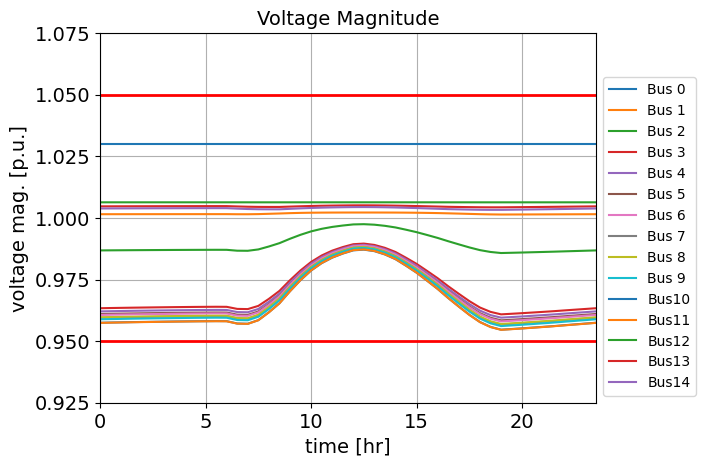

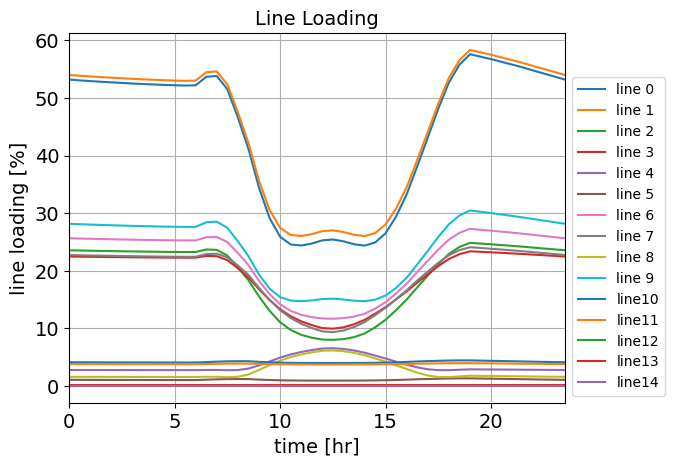

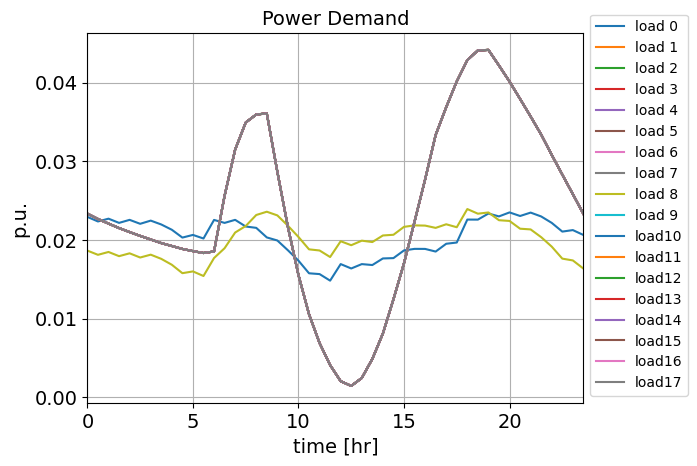

In [53]:
vm_pu = pd.read_excel("UTownMGScen2/res_bus/vm_pu.xlsx", index_col=0)
plt.figure()
plt.rc('font', size =14)
x,Y = np.shape(vm_pu)
for i in range(Y):
    plt.plot(time,vm_pu[i], label = "Bus{0:2d}".format(vm_pu.columns.values[i]))
plt.xlabel("time [hr]")
plt.ylabel("voltage mag. [p.u.]")
plt.title("Voltage Magnitude", fontsize = 14)
plt.xlim(time[0],time[-1])
plt.axhline(0.95,c='red',lw=2)
plt.axhline(1.05,c='red',lw=2)
plt.yticks(np.linspace(0.925,1.075, 7))
plt.legend(loc = "lower left",bbox_to_anchor = (1,0), fontsize =10)
plt.grid()
plt.show()


line_loading = pd.read_excel("UTownMGScen2/res_line/loading_percent.xlsx", index_col=0)
plt.figure()
x,Y = np.shape(line_loading)
for i in range(Y):
    plt.plot(time,line_loading[i], label = "line{0:2d}".format(line_loading.columns.values[i]))
plt.xlim(time[0],time[-1])
plt.legend(loc = "lower left",bbox_to_anchor = (1,0), fontsize =10)
plt.xlabel("time [hr]")
plt.ylabel("line loading [%]")
plt.title("Line Loading", fontsize =14)
plt.grid()
plt.show()


load = pd.read_excel("UTownMGScen2/res_load/p_mw.xlsx", index_col=0)
plt.figure()
x,Y = np.shape(load)
for i in range(Y):
    plt.plot(time,load[i], label = "load{0:2d}".format(load.columns.values[i]))
plt.xlim(time[0],time[-1])
plt.xlabel("time [hr]")
plt.ylabel("p.u.")
plt.title("Power Demand", fontsize =14)
plt.legend(loc = "lower left",bbox_to_anchor = (1,0), fontsize =10)
plt.grid()
plt.show()

## Scenario 3 - EV Charging Activity [2 DCFC at all loads (exclude load 0 and 8) at 0900 and 1200 and 1700]

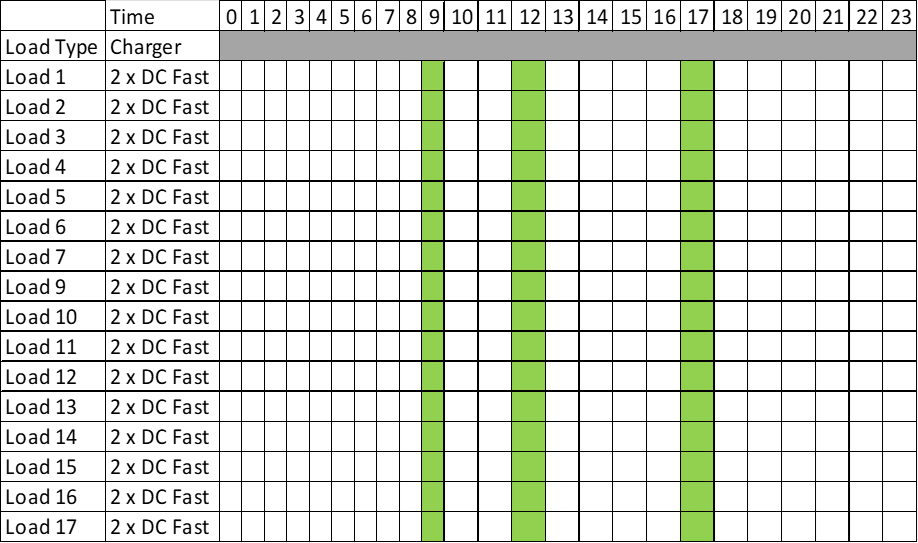

#### Grid Setup

In [54]:
net = pn.create_cigre_network_mv(with_der="all")
pp.drop_elements_simple(net,element='sgen',idx=8) #dropping wind turbine
pp.drop_elements_simple(net,element='sgen',idx=9) #dropping Residential fuel cell 1
pp.drop_elements_simple(net,element='sgen',idx=12) #dropping Residential fuel cell 2
pp.drop_elements_simple(net,element='sgen',idx=10) #dropping CHP diesel
pp.drop_elements_simple(net,element='sgen',idx=11) #dropping Fuel cell
net.storage.iloc[0,2]=1
net.storage.iloc[0,4]=1
net.storage.iloc[0,5]=0.3
net.storage.iloc[0,7]=0.5
net.storage.iloc[0,-2]=-1
net.storage.iloc[0,-1]=1
net.storage.iloc[1,2]=1
net.storage.iloc[1,4]=1
net.storage.iloc[1,5]=0.3
net.storage.iloc[1,7]=0.5
net.storage.iloc[1,-2]=-1
net.storage.iloc[1,-1]=1

#### All Loads (Exclude load 0 and 8)

In [55]:
net_load_demand_PV_scen3 = power_demand_resd*5/7+power_demand_non_resd*0.8-PV_PU*(max(SGP_pwr)-210*0.3)*7/9 #Load power demand does not reach zero
net_load_demand_PV_scen3 = net_load_demand_PV_scen3.to_numpy()

In [56]:
net_load_demand_PV_scen3[18:20] = net_load_demand_PV_scen3[18:20] + DCFC_load*16
net_load_demand_PV_scen3[24:26] = net_load_demand_PV_scen3[24:26] + DCFC_load*16
net_load_demand_PV_scen3[34:36] = net_load_demand_PV_scen3[34:36] + DCFC_load*16

In [57]:
print(net.load.iloc[:,2]*1000) #kw
total = 0
for i in range(len(net.load.iloc[:,2])):
    if ((i!=0)&(i!=8)):
        #print(i)
        total = total+net.load.iloc[i,2]*1000
print( "In CIGRE network, max possible active power demand by all load (exlude 0 and 8) = " + str(total) + ' kW')
print( "In UTown MG, max active power demand by 5/7 of resd load and 0.8 of non-resd load (with 7/9 PV power generation) = " + str(max(net_load_demand_PV_scen3)) + ' kW')
power_scale_factor = max(net_load_demand_PV_scen3)/total
power_scale_factor

0     14994.00
1       276.45
2       431.65
3       727.50
4       548.05
5       586.85
6       475.30
7       329.80
8     14994.00
9       208.55
10     4845.00
11      225.25
12       76.50
13      573.75
14       68.00
15     5016.00
16       34.00
17      331.50
Name: p_mw, dtype: float64
In CIGRE network, max possible active power demand by all load (exlude 0 and 8) = 14754.150000000001 kW
In UTown MG, max active power demand by 5/7 of resd load and 0.8 of non-resd load (with 7/9 PV power generation) = 1460.3559342425965 kW


0.09897933355988629

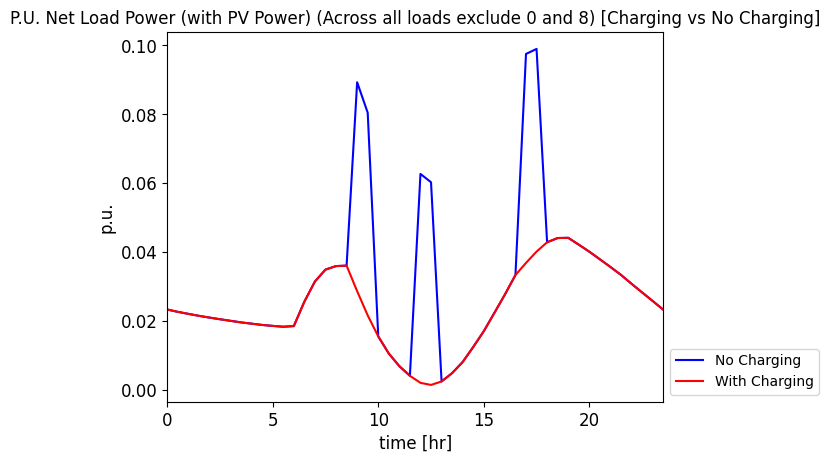

In [58]:
load_PU_scen3=(net_load_demand_PV_scen3/max(net_load_demand_PV_scen3)*power_scale_factor)
plt.figure()
plt.rc('font', size =12)
plt.rcParams['axes.titlesize'] =12
plt.title('P.U. Net Load Power (with PV Power) (Across all loads exclude 0 and 8) [Charging vs No Charging]',fontsize=12)
plt.plot(time,load_PU_scen3,'blue', label = "No Charging")
plt.plot(time,load_PU,'red', label = "With Charging")
plt.legend(loc = "lower left",bbox_to_anchor = (1,0), fontsize =10)
plt.xlim(time[0],time[-1])
plt.ylabel('p.u.')
plt.xlabel('time [hr]')
plt.show()

#### Residential (Load 0)

In [59]:
load_0 = power_demand_resd*2/7-PV_PU*(max(SGP_pwr)-210)/9
#load0_max
PU_load_0_scen3=(load_0/load0_max)
PU_load_0_scen3 = PU_load_0_scen3.to_numpy()

#### Non-Residential (Load 8)

In [60]:
load_8 = power_demand_non_resd*0.2-PV_PU*(max(SGP_pwr)-210)/9
#load8_max
PU_load_8_scen3=(load_8/load8_max)

#### Results

In [61]:
num_intervals = len(power_demand_non_resd)
time_steps = np.arange(num_intervals)
start_time = pd.to_datetime("2025-04-23 00:00:00")
index_time = start_time + pd.to_timedelta(time_steps * 0.5, unit='h')  #half-hourly
df_load_profile = pd.DataFrame(load_PU_scen3, index=index_time,columns=['load'])
ds = DFData(df_load_profile)
df_load_profile_0 = pd.DataFrame(PU_load_0_scen3, index=index_time,columns=['load'])
ds_0 = DFData(df_load_profile_0)
df_load_profile_8 = pd.DataFrame(PU_load_8_scen3, index=index_time,columns=['load'])
ds_8 = DFData(df_load_profile_8)
for i in net.load.index:
    if (i==0):
        ConstControl(net,element = 'load',variable='p_mw',element_index=i,data_source=ds_0, profile_name='load') 
    elif (i==8):
        ConstControl(net,element = 'load',variable='p_mw',element_index=i,data_source=ds_8, profile_name='load')
    else:
        ConstControl(net,element = 'load',variable='p_mw',element_index=i,data_source=ds, profile_name='load')
df_load_profile = pd.DataFrame(PV_PU*0.3, index=index_time,columns=['sgen'])
ds = DFData(df_load_profile)
for i in net.sgen.index:
    ConstControl(net,element = 'sgen',variable='p_mw',element_index=i,data_source=ds, profile_name='sgen')
time_steps_for_run = df_load_profile.index

In [62]:
ow = OutputWriter(net, time_steps, output_path='UTownMGScen3', output_file_type=".xlsx", log_variables=list())
# these variables are saved to the harddisk after / during the time series loop
ow.log_variable('res_load', 'p_mw')
ow.log_variable('res_bus', 'vm_pu')
ow.log_variable('res_line', 'loading_percent')

In [63]:
run_timeseries(net,time_steps_for_run)

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 75.57it/s]


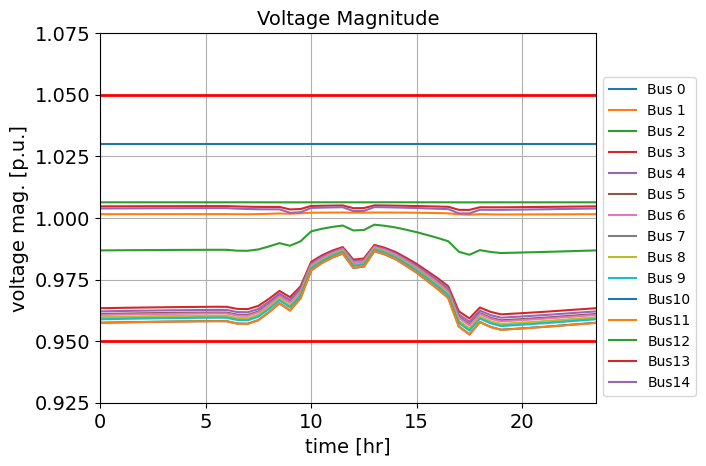

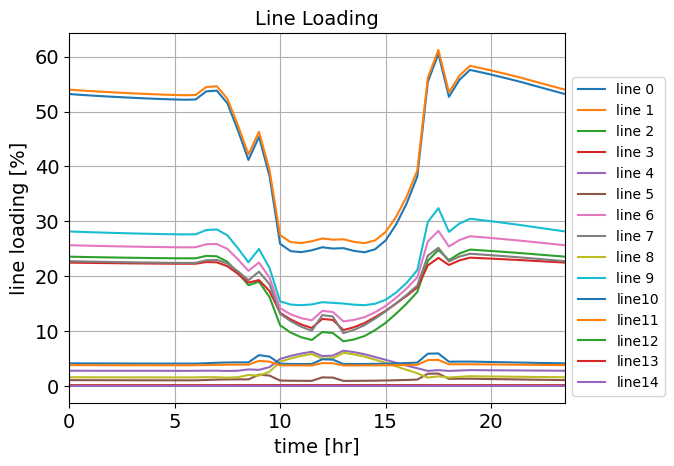

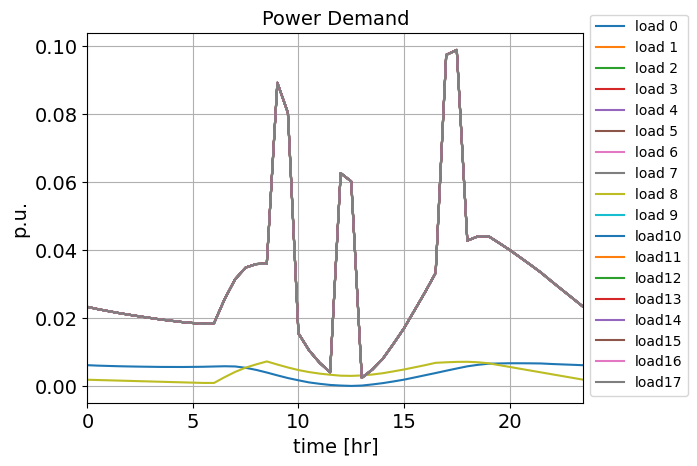

In [64]:
vm_pu = pd.read_excel("UTownMGScen3/res_bus/vm_pu.xlsx", index_col=0)
plt.figure()
plt.rc('font', size =14)
x,Y = np.shape(vm_pu)
for i in range(Y):
    plt.plot(time,vm_pu[i], label = "Bus{0:2d}".format(vm_pu.columns.values[i]))
plt.xlabel("time [hr]")
plt.ylabel("voltage mag. [p.u.]")
plt.title("Voltage Magnitude", fontsize = 14)
plt.xlim(time[0],time[-1])
plt.axhline(0.95,c='red',lw=2)
plt.axhline(1.05,c='red',lw=2)
plt.yticks(np.linspace(0.925,1.075, 7))
plt.legend(loc = "lower left",bbox_to_anchor = (1,0), fontsize =10)
plt.grid()
plt.show()


line_loading = pd.read_excel("UTownMGScen3/res_line/loading_percent.xlsx", index_col=0)
plt.figure()
x,Y = np.shape(line_loading)
for i in range(Y):
    plt.plot(time,line_loading[i], label = "line{0:2d}".format(line_loading.columns.values[i]))
plt.xlim(time[0],time[-1])
plt.legend(loc = "lower left",bbox_to_anchor = (1,0), fontsize =10)
plt.xlabel("time [hr]")
plt.ylabel("line loading [%]")
plt.title("Line Loading", fontsize =14)
plt.grid()
plt.show()


load = pd.read_excel("UTownMGScen3/res_load/p_mw.xlsx", index_col=0)
plt.figure()
x,Y = np.shape(load)
for i in range(Y):
    plt.plot(time,load[i], label = "load{0:2d}".format(load.columns.values[i]))
plt.xlim(time[0],time[-1])
plt.xlabel("time [hr]")
plt.ylabel("p.u.")
plt.title("Power Demand", fontsize =14)
plt.legend(loc = "lower left",bbox_to_anchor = (1,0), fontsize =10)
plt.grid()
plt.show()